# Computation of annotation enrichment in a genetic set 

This code excerpt shows how to use the annotation enrichment computation function in a genetic set.
The funciton return a dataframe of binom and hypergeometric p-value (<= 0.05) and for each p-value a fdr correction with alpha = 0.05.   

In the second part of the code we will compare the results obtained with the Great webserver and between the binomial and hypergeometric probability

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
from seaborn import scatterplot as sp

import warnings
warnings.filterwarnings('ignore')

## I Compute the p-values

In [5]:
enrichment_fdr = great.tl.enrichment(
    test="../../data/human/test_genomic_region.bed",
    regdom_file="../../data/human/regulatory_domain.bed",
    chr_size_file="../../data/human/chr_size.bed",
    annotation="../../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    alpha=0.05,
    correction=("fdr",0.05)
    )

In [6]:
enrichment_fdr

,go_term,binom_p_value,hypergeom_p_value,binom_fdr_correction,hypergeom_fdr_correction
GO:0001523,retinoid metabolic process,4.70169e-04,1.76153e-01,2.09985e-03,2.85108e-01
GO:0002162,dystroglycan binding,1.29786e-05,4.02252e-02,1.24343e-04,1.44811e-01
GO:0005200,structural constituent of cytoskeleton,3.73899e-03,2.76213e-01,1.12170e-02,3.75447e-01
GO:0005201,extracellular matrix structural constituent,1.34489e-03,3.51826e-02,4.95080e-03,1.40626e-01
GO:0005509,calcium ion binding,8.66371e-01,9.10282e-01,9.01268e-01,9.29051e-01
...,...,...,...,...,...
GO:0002087,regulation of respiratory gaseous exchange by ...,2.07002e-05,3.74057e-02,1.70777e-04,1.40626e-01
GO:0003682,chromatin binding,4.09979e-01,7.21532e-01,4.98011e-01,7.72234e-01
GO:0030426,growth cone,2.73584e-02,3.29606e-01,5.88800e-02,4.22863e-01
GO:0051968,"positive regulation of synaptic transmission, ...",5.94155e-04,8.15551e-02,2.53905e-03,1.89233e-01


In [7]:
enrichment_bonferroni = great.tl.enrichment(
    test="../../data/human/test_genomic_region.bed",
    regdom_file="../../data/human/regulatory_domain.bed",
    chr_size_file="../../data/human/chr_size.bed",
    annotation="../../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    alpha=0.05,
    correction=("bonferroni",0.05),
    )

In [22]:
enrichment_bonferroni.sort_values("binom_p_value")

,go_term,binom_p_value,hypergeom_p_value,binom_bonferroni_correction,hypergeom_bonferroni_correction
GO:0045887,positive regulation of synaptic growth at neur...,5.17744e-13,2.92750e-03,3.07540e-10,1
GO:0044721,"protein import into peroxisome matrix, substra...",4.83812e-10,2.92750e-03,2.87384e-07,1
GO:0036250,peroxisome transport along microtubule,4.83812e-10,2.92750e-03,2.87384e-07,1
GO:0016561,"protein import into peroxisome matrix, translo...",6.31131e-10,5.84656e-03,3.74892e-07,1
GO:0047485,protein N-terminus binding,1.29450e-09,5.03770e-03,7.68931e-07,1
...,...,...,...,...,...
GO:0050911,detection of chemical stimulus involved in sen...,1,3.69018e-01,1,1
GO:0004984,olfactory receptor activity,1,3.97213e-01,1,1
GO:0005652,nuclear lamina,1,2.03160e-02,1,1
GO:0005694,chromosome,1,3.64277e-01,1,1


In [11]:
enrichment_tot = enrichment_fdr 
enrichment_tot["binom_bonferroni_correction"] = enrichment_bonferroni["binom_bonferroni_correction"]
enrichment_tot["hypergeom_bonferroni_correction"] = enrichment_bonferroni["hypergeom_bonferroni_correction"]
enrichment_tot = enrichment_tot[["binom_p_value","binom_bonferroni_correction","binom_fdr_correction","hypergeom_p_value","hypergeom_bonferroni_correction","hypergeom_fdr_correction"]]
enrichment_tot = enrichment_tot.reset_index().rename(columns={"index":"id","binom_bonferroni_correction":"binom_bonferroni","binom_fdr_correction":"binom_fdr","hypergeom_p_value":"hyper_p_value","hypergeom_bonferroni_correction":"hyper_bonferroni","hypergeom_fdr_correction":"hyper_fdr"})
enrichment_tot = enrichment_tot.loc[enrichment_tot["binom_p_value"]<=0.05]

## II Compare to GREAT webserver  

### II.1 Import the data

In [12]:
great_webserver = pd.read_csv("../../data/test/01_output_great_webserver.tsv",sep="\t",comment="#",
                    names=["ontologie","term_name","ID","binom_p_value","binom_bonferroni","binom_fdr","hyper_p_value","hyper_bonferroni","hyper_fdr"],index_col=False,
                    dtype={"term_name":"object", "ID":"object","binom_p_value":"float64", "binom_bonferroni":"float64", "binom_fdr":"float64", "hyper_p_value":"float64", "hyper_bonferroni":"float64", "hyper_fdr":"float64"})
great_webserver.rename(columns={"ID":"id"},inplace=True)
del great_webserver["ontologie"]
del great_webserver["term_name"]

### II.2 Compare the results between greatpy and great 

#### II.2.1 Preprocessing

In [13]:
before_pp = enrichment_tot.shape[0]

In [14]:
enrichment_tot = enrichment_tot[enrichment_tot["id"].isin(list(great_webserver["id"]))]
enrichment_tot = enrichment_tot.sort_values("id")
after_pp = enrichment_tot.shape[0]

In [15]:
great_webserver = great_webserver[great_webserver["id"].isin(list(enrichment_tot["id"]))]
great_webserver = great_webserver.sort_values("id")

In [16]:
binom_greatpy = hyper_greatpy = binom_great = hyper_great = []
for i in range(enrichment_tot.shape[0]) : 
    curr_enrichment = enrichment_tot.iloc[i]
    curr_great_webserver = great_webserver.loc[great_webserver["id"]==curr_enrichment["id"]]
    binom_greatpy.append(float(curr_enrichment["binom_p_value"]))
    hyper_greatpy.append(float(curr_enrichment["hyper_p_value"]))
    binom_great.append(float(curr_great_webserver["binom_p_value"]))
    hyper_great.append(float(curr_great_webserver["hyper_p_value"]))
binom = pd.DataFrame({"binom_greatpy":binom_greatpy,"binom_great":binom_great})
hyper = pd.DataFrame({"hyper_greatpy":hyper_greatpy,"hyper_great":hyper_great})

#### II.2.b Graphical

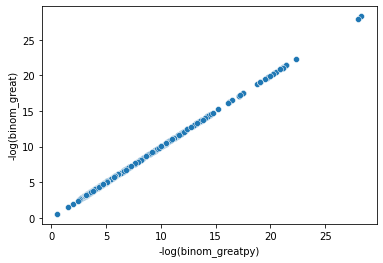

In [17]:
pl=great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_great")

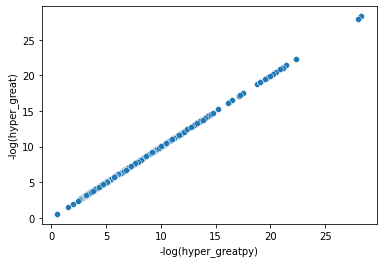

In [18]:
great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_great")

#### II.2.c Statistics

In [19]:
def stat(binom_great_list_list, hyper_great_listpy_list,binom_great_list,hyper_great_list) : 
    return pd.DataFrame({
        "binom": [cov(m = binom_great_list_list, y = binom_great_list)[0][1],pearsonr(binom_great_list_list,binom_great_list)[0]],
        "hyper":[cov(m = hyper_great_listpy_list, y = hyper_great_list)[0][1],pearsonr(hyper_great_listpy_list,hyper_great_list)[0]]},
        index=["correlation_coefficient","pearson"])

In [20]:
stat(binom_greatpy, hyper_greatpy,binom_great,hyper_great)

,binom,hyper
correlation_coefficient,1.19906e-03,1.19906e-03
pearson,1.00000e+00,1.00000e+00


In [21]:
print(before_pp)
print(after_pp)

310
102


We went from 310 ontology terms in greatpy output to 102 ontology terms by selecting the GO identifiers present in both greatpy and great 

But when two ontology terms are selected they have the same binomial and hypergeometric probability value 